# CS5489 - Tutorial 7
## Image Segmentation using Clustering

In this tutorial you will use clustering algorithms to generate a segmentation of an image.  An image segmentation is a separation of an image into regions belonging to distinct objects.
First we need to initialize Python.  Run the below cell.

In [4]:
%matplotlib inline
import matplotlib_inline  # setup output image format

matplotlib_inline.backend_inline.set_matplotlib_formats('jpg')
# jpg is better for images in this tutorial
import matplotlib.pyplot as plt
from numpy import *
from sklearn import *
import glob
import os
import skimage.io
import skimage.color
import skimage.util
import warnings
warnings.simplefilter('ignore')
random.seed(100)

##  Loading Data and Pre-processing
Next we need to load the data.  Download `imgdb.zip`, and unzip it in the same directory as this ipynb file.  Then run the following cell to load the image data.

In [5]:
filelist = glob.glob('imgdb/jpg/*.jpg')
gtpath = 'imgdb/gtruth/'
if len(filelist) == 0:
    warn.error("Could not find imgdb directory!  " +
               "Make sure you put it here: " + os.getcwd())
else:
    imgdata = []
    gtdata = []

    # load image data
    for f in filelist:
        # load image - byte [0 to 255]
        img = skimage.io.imread(f)

        (fdir1, fname) = os.path.split(f)

        # load GT segmentation (non-consecutive integers)
        gname = gtpath + fname[:-4] + "-gt.png"
        gtimg = skimage.io.imread(gname)

        # convert to consecutive integers
        cl = unique(gtimg)
        gtimg0 = gtimg.copy().astype(float64)
        for i in range(len(cl)):
            gtimg0[gtimg == cl[i]] = i

        imgdata.append(img)
        gtdata.append(gtimg0)
print(len(imgdata))

14


There are 14 images.  Each image also has a ground-truth segmentation that was created by a human annotation.  Here is an example:

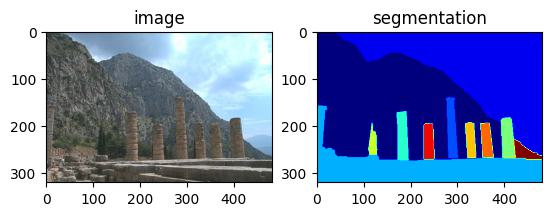

In [6]:
plt.subplot(1, 2, 1)
plt.imshow(imgdata[6], aspect='equal')
plt.title('image')
plt.subplot(1, 2, 2)
plt.imshow(gtdata[6], aspect='equal', cmap='jet')
plt.title('segmentation');

##  Clustering with Color Features
To segment an image, we will extract features from each pixel location.  Then, we cluster the extracted features into groups.  Pixel location that are clustered into the same group form a segment.

For the features, we will use the "Lab" colorspace, rather than the RGB colors.  Also, we will ignore the "L" feature, which is brightness, resulting in a 2-dimensional color feature space (a, b). Here are a few helper functions: 1) extract Lab features along a regular grid on the image; 2) convert cluster labels into a segmentation image; 3) color a segmentation image using colors from the original image.

In [7]:
def getfeatures(img, segm=None, stepsize=7, use_loc=False):
    """
    getfeatures - extract features from an image
     [X, Y, L] = getfeatures(img, stepsize)
     INPUT
     img      - the image   [type = np.ndarray or Image]
     segm     - the gt segmentation (optional)
     stepsize - window stepsize
     OUTPUT
      X   - the features: each row is a feature vector  [type = np.ndarray]
      Y   - the GT segment labels for each feature (if segm is provided)
      L   - dictionary containing location information of each feature
    """
    winsize = 7  # ensure it is an odd number
    if stepsize > winsize:
        raise Exception('stepsize larger than window size')
    # convert to LAB
    yimg = skimage.color.rgb2lab(img)

    offset = floor((winsize - 1) / 2)
    sy, sx, sc = img.shape

    if use_loc:
        Xdim = 4
    else:
        Xdim = 2

    # extract window patches with stepsize
    patches = skimage.util.view_as_windows(yimg, (winsize, winsize, 3), step=stepsize)
    psize = patches.shape

    # get coordinates of windows
    rangex = arange(psize[1]) * stepsize + offset
    rangey = arange(psize[0]) * stepsize + offset

    X = zeros((psize[0] * psize[1], Xdim));

    if segm is None:
        Y = None
    else:
        Y = zeros((X.shape[0],))

    i = 0
    for x in range(psize[1]):
        for y in range(psize[0]):
            myu = mean(patches[y, x, 0, :, :, 1].flatten())
            myv = mean(patches[y, x, 0, :, :, 2].flatten())
            myy = int(rangey[y])
            myx = int(rangex[x])

            if use_loc:
                X[i, :] = [myu, myv, myx, myy]
            else:
                X[i, :] = [myu, myv]

            if Y is not None:
                Y[i] = segm[myy, myx]

            i = i + 1

    L = {'rangex': rangex, 'rangey': rangey, 'offset': offset, 'sx': sx, 'sy': sy, 'stepsize': stepsize,
         'winsize': winsize}
    return X, Y, L


def labels2seg(Y, L):
    """
    labels2segm - form a segmentation image using cluster labels
    segm = labels2segm(Y, L)
    Y - cluster labels for each location
    L - location dictionary from getfeatures
    segm - output segmentation image
    """
    segm = zeros((L['sy'], L['sx']))
    # <= offset if floor((winsize-1)/2)>= floor(stepsize/2) 
    rstep = int(floor(L['stepsize'] / 2.0))
    stepbox = range(-rstep, L['stepsize'] - rstep)
    rx = asarray(L['rangex'], dtype=int) + int(L['offset'])
    ry = asarray(L['rangey'], dtype=int) + int(L['offset'])
    Y_reshaped = Y.reshape((ry.size, rx.size), order='F')
    for i in stepbox:
        for j in stepbox:
            segm[ix_(ry + j, rx + i)] = Y_reshaped
    ## Now fil in the borders if they are missing
    minx = min(rx) + stepbox[0] - 1
    maxx = max(rx) + stepbox[-1] + 1
    miny = min(ry) + stepbox[0] - 1
    maxy = max(ry) + stepbox[-1] + 1

    if 0 <= minx:
        ## fill in left edge
        segm[:, 0:minx + 1] = segm[:, minx + 1].reshape((-1, 1))
    if maxx < L['sx']:
        ## fill in right edge
        segm[:, maxx:] = segm[:, maxx - 1].reshape((-1, 1))
    if 0 < miny:
        ## fill in top edge
        segm[0:miny + 1, :] = segm[miny + 1, :].reshape((1, -1))
    if maxy < L['sy']:
        ## fill in bottom edge
        segm[maxy:, :] = segm[maxy - 1, :].reshape((1, -1))
    return segm


def colorsegms(segm, img):
    """
    colorsegm - color a segmentation based on the image
    csegm = colorsegm(segm, img)
    segm = the segmentation image  [type = np.ndarray]
    img = the original image    [type = np.ndarray (or Image)]
    csegm = the colored segmentation -- each segment is colored based on the 
            average pixel color within the segment.
    """
    img = asarray(img).copy()
    if segm.shape[0:2] != img.shape[0:2]:
        raise Exception('The shape of segmentation and image are not consistent')
    rimg, gimg, bimg = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    for i in range(0, int(max(segm.flatten())) + 1):
        # assume label starts from 1
        ind = (segm == i)
        rimg[ind] = mean(rimg[ind].flatten())
        gimg[ind] = mean(gimg[ind].flatten())
        bimg[ind] = mean(bimg[ind].flatten())
    # handle outliers from DBSCAN
    ind = (segm == -1)
    rimg[ind] = 0
    gimg[ind] = 0
    bimg[ind] = 0
    return img

Next, we use the `getfeatures` function to extract features from an image.  `X` contains the feature vectors. `L` contains information about where each features was extracted, which is used later generate the segmentation.

(3060, 2)


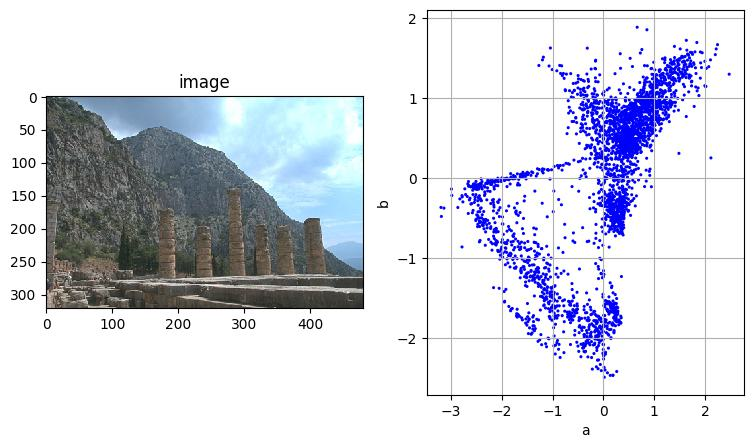

In [8]:
# image to use
img = imgdata[6]
gt = gtdata[6]

# extract features, each row is a feature vector
Xo, Ytrue, L = getfeatures(img, gt)
print(Xo.shape)

# normalize features
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(Xo)

# view the image
plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
plt.imshow(img, interpolation='nearest')
plt.title("image")

# view the features
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c='b', s=5, edgecolor='none')
plt.ylabel('b');
plt.xlabel('a');
plt.grid(True)

Here is the segmented image, with the segment labels shown as colors.  The goal is to recoever these labels using clustering. 

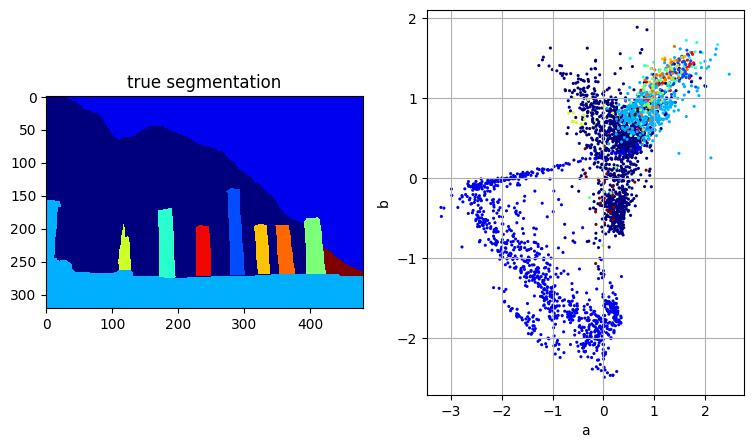

In [9]:
# view the image
plt.figure(figsize=(9, 5))

plt.subplot(1, 2, 1)
plt.imshow(gt, interpolation='nearest', cmap='jet')
plt.title("true segmentation")

# view the features
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=Ytrue, s=5, edgecolor='none', cmap='jet')
plt.ylabel('b');
plt.xlabel('a');
plt.grid(True)

Now use a clustering algorithm to group the data into 5 clusters.

In [10]:
### INSERT YoUR CODE HERE

In [11]:
km = cluster.KMeans(n_clusters=5, random_state=4487)
Y = km.fit_predict(X)  # cluster data, and return labels

Once you have the cluster labels (Y), use the below code to generate the segmentation image and view it.  You can also view the scatter plot with `showscatter`.

In [12]:
def showsegm(segm, img):
    "show a segmentation"

    # fill segmentation with colors from the image
    csegm = colorsegms(segm, img)

    # view the images, segmentation, and ground-truth
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img, interpolation='nearest')
    plt.title('image')
    plt.subplot(1, 3, 2)
    plt.imshow(segm, interpolation='nearest', cmap='jet')
    plt.title('segmentation')
    plt.subplot(1, 3, 3)
    plt.imshow(gt, interpolation='nearest', cmap='jet')
    plt.title("ground truth")

    return segm


def showscatter(X, Y):
    "show a scatter plot of clusters"

    if X.shape[1] == 2:
        plt.figure()
        plt.scatter(X[:, 0], X[:, 1], c=Y, s=5, edgecolor='none', cmap='jet')
        plt.grid(True)
        plt.xlabel('a')
        plt.ylabel('b')
    else:
        plt.figure(figsize=(12, 3))

        plt.subplot(1, 4, 1)
        plt.scatter(X[:, 0], X[:, 1], c=Y, s=5, edgecolor='none', cmap='jet')
        plt.xlabel('a');
        plt.ylabel('b');
        plt.grid(True)

        plt.subplot(1, 4, 2)
        plt.scatter(X[:, 2], X[:, 3], c=Y, s=5, edgecolor='none', cmap='jet')
        plt.xlabel('x-pos');
        plt.ylabel('y-pos');
        plt.grid(True)

        plt.subplot(1, 4, 3)
        plt.scatter(X[:, 2], X[:, 0], c=Y, s=5, edgecolor='none', cmap='jet')
        plt.xlabel('x-pos');
        plt.ylabel('a');
        plt.grid(True)

        plt.subplot(1, 4, 4)
        plt.scatter(X[:, 3], X[:, 1], c=Y, s=5, edgecolor='none', cmap='jet')
        plt.xlabel('y-pos');
        plt.ylabel('b');
        plt.grid(True)

        plt.tight_layout()

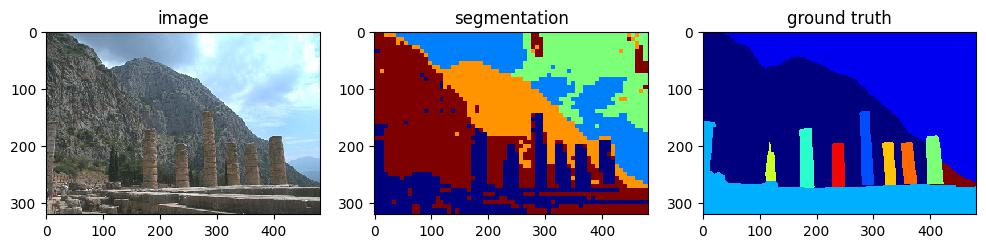

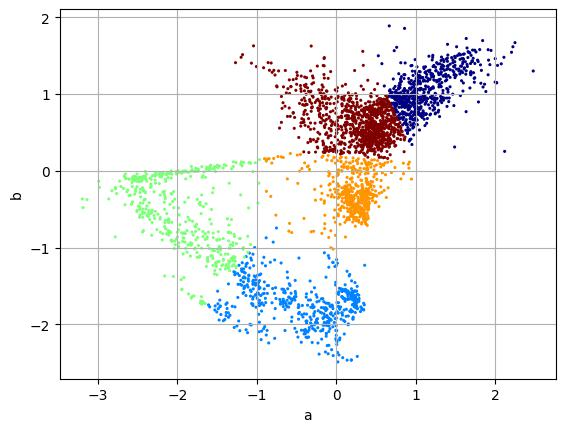

In [13]:
# convert cluster labels to a segmentation image
segm = labels2seg(Y, L)

# show the segmentation
showsegm(segm, img)

# show the scatter plot
showscatter(X, Y)

Next we evaluate the segmentation with the ground-truth provided by a human annotator.  We cannot just check that the cluster assignments for each pixel are the same, since the cluster indices can be permuted.  We will use the _Adjusted Rand Index_, which calculates how often a pair of pixels is assigned correctly to the same cluster or not.  Use the below code to calculate the ARI. Higher values are better, and the maximum value is 1. 

In [14]:
# calculate ARI
#ari = metrics.adjusted_rand_score(gt.flatten(), segm.flatten())
ari = metrics.adjusted_rand_score(Ytrue, Y)
print("ARI =", ari)

ARI = 0.41014157099804266


Try different clustering algorithms and settings (K, bandwidth, etc) to get the best segmentation as measured by ARI. 

In [15]:
### INSERT YOUR CODE HERE

In [16]:
aris = []
for n_cluster in range(1, 10):
    km = cluster.KMeans(n_clusters=n_cluster, random_state=4487)
    Y = km.fit_predict(X)
    aris.append(metrics.adjusted_rand_score(Ytrue, Y))
print("Kmeans best ARI:{:.3f} with K:{}".format(max(aris), range(1, 10)[argmax(aris)]))

for convariance in ['full', 'diag', 'spherical']:
    aris = []
    for n_cluster in range(1, 10):
        gmm = mixture.GaussianMixture(n_components=n_cluster, random_state=4487, covariance_type=convariance, n_init=10)
        Y = gmm.fit_predict(X)
        aris.append(metrics.adjusted_rand_score(Ytrue, Y))
    print("GMM {} best ARI:{:.3f} with components:{}".format(convariance, max(aris), range(1, 10)[argmax(aris)]))

Kmeans best ARI:0.579 with K:4
GMM full best ARI:0.519 with components:3
GMM diag best ARI:0.585 with components:4
GMM spherical best ARI:0.550 with components:4


In [17]:
#BayesianGaussian
for covariance in ['full', 'diag', 'spherical']:
    aris = []
    for n_components in range(1, 10):
        dpgmm = mixture.BayesianGaussianMixture(covariance_type=covariance, weight_concentration_prior=1,
                                                n_components=n_components, max_iter=5000, random_state=4487)
        Y = dpgmm.fit_predict(X)
        aris.append(metrics.adjusted_rand_score(Ytrue, Y))
    print(
        'Bayesian GMM {} best ARI:{:.3f} with components:{}'.format(covariance, max(aris), range(1, 20)[argmax(aris)]))

# MeanShift
aris = []
for bandwidth in linspace(1, 5, 10):
    ms = cluster.MeanShift(bandwidth=bandwidth, n_jobs=8)
    Y = ms.fit_predict(X)
    aris.append(metrics.adjusted_rand_score(Ytrue, Y))
print('MeanShift best ARI:{:.3f} with bandwidth:{:.3f}'.format(max(aris), linspace(0.1, 5, 10)[argmax(aris)]))

#Spectral
aris = []
for n_clusters in range(1, 10):
    sc = cluster.SpectralClustering(n_clusters=n_clusters, affinity='rbf', gamma=1, assign_labels='discretize',
                                    n_jobs=-1)
    Y = sc.fit_predict(X)
    aris.append(metrics.adjusted_rand_score(Ytrue, Y))
print('SpectralClustering best ari:{:.3f} with K:{}'.format(max(aris), range(1, 10)[argmax(aris)]))

Bayesian GMM full best ARI:0.450 with components:2
Bayesian GMM diag best ARI:0.574 with components:4
Bayesian GMM spherical best ARI:0.538 with components:4
MeanShift best ARI:0.469 with bandwidth:0.644
SpectralClustering best ari:0.580 with K:4


_Which algorithm performs the best?  Why?_
- **INSERT YOUR ANSWER HERE**
- GMM with diag covariance is the best. The best ARI is 0.585 with 4 components.
- Fisrtly, diag covariance is better, because diagonal covariance matrix assumes that the features are independent of each other and therefore the covariance between them is zero. This makes it easier to interpret the model and understand the parameters that are being estimated. Additionally, a diagonal covariance matrix can be useful if the data has a large number of features.
- Secondaly, GMM take into account the uncertainty associated with each data point and also provide a more flexible representation of the data, as they allow for clusters with different shapes and sizes. Additionally, GMMs are able to model different clusters that have different levels of certainty, which can help to improve the accuracy of the model.

## Color and Position Features
You may notice that the segmentation is not spatially smooth -- that is, there are some "loner" pixels that are not the same cluster as the surrounding pixels.  This is because we are only clustering color.  One way to fix this is to include the (x,y) coordinate of the pixel as part of the feature vector.  This way, clusters will have pixels that are spatially close together.

The below code extracts a 4-dimensional feature vector, where the first 2 features are the color channels and the last 2 features are the position.

In [18]:
# extract features with location
Xo, Ytrue, L = getfeatures(img, gt, use_loc=True)
print(Xo.shape)

# normalize features
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(Xo)

# rescale position features
# larger values emphasize clustering by position more
X[:, 2:4] *= 0.5

(3060, 4)


Here are plots of the 4 features.

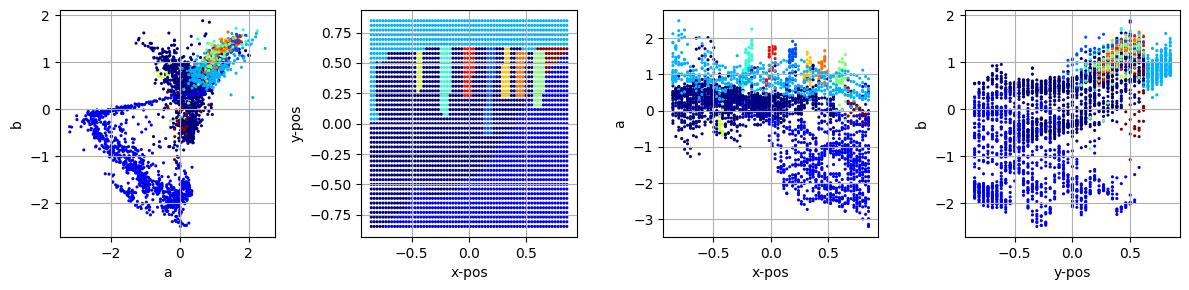

In [19]:
showscatter(X, Ytrue)

Run clustering algorithms on the 4-dimensional data.  Try different algorithms and parameters to get the best ARI.

In [20]:
### INSERT YOUR CODE HERE

In [21]:
aris = []
for n_cluster in range(1,10):
    km = cluster.KMeans(n_clusters=n_cluster, random_state=4487)
    Y = km.fit_predict(X)
    aris.append(metrics.adjusted_rand_score(Ytrue, Y))
print("Kmeans best ARI:{:.3f} with K:{}".format(max(aris), range(1, 10)[argmax(aris)]))

aris = []
for covariance in ['full', 'diag', 'spherical']:
    aris = []
    for n_cluster in range(1, 10):
        gmm = mixture.GaussianMixture(n_components=n_cluster, random_state=4487, covariance_type=covariance, n_init=10)
        Y = gmm.fit_predict(X)
        aris.append(metrics.adjusted_rand_score(Ytrue, Y))
    print("GMM {} best ARI:{:.3f} with components:{}".format(covariance, max(aris), range(1, 10)[argmax(aris)]))

Kmeans best ARI:0.633 with K:4
GMM full best ARI:0.675 with components:4
GMM diag best ARI:0.485 with components:4
GMM spherical best ARI:0.639 with components:4


In [22]:
aris = []
for covariance in ['full', 'diag', 'spherical']:
    aris = []
    for n_components in range(1, 10):
        dpgmm = mixture.BayesianGaussianMixture(covariance_type=covariance, weight_concentration_prior=1,
                                                n_components=n_components, max_iter=5000, random_state=4487)
        Y = dpgmm.fit_predict(X)
        aris.append(metrics.adjusted_rand_score(Ytrue, Y))
    print(
        'Bayesian GMM {} best ARI:{:.3f} with components:{}'.format(covariance, max(aris), range(1, 20)[argmax(aris)]))

# MeanShift
aris = []
for bandwidth in linspace(1, 5, 10):
    ms = cluster.MeanShift(bandwidth=bandwidth, n_jobs=8)
    Y = ms.fit_predict(X)
    aris.append(metrics.adjusted_rand_score(Ytrue, Y))
print('MeanShift best ARI:{:.3f} with bandwidth:{:.3f}'.format(max(aris), linspace(0.1, 5, 10)[argmax(aris)]))

#Spectral
aris = []
for n_clusters in range(1, 10):
    sc = cluster.SpectralClustering(n_clusters=n_clusters, affinity='rbf', gamma=1, assign_labels='discretize',
                                    n_jobs=-1)
    Y = sc.fit_predict(X)
    aris.append(metrics.adjusted_rand_score(Ytrue, Y))
print('SpectralClustering best ari:{:.3f} with K:{}'.format(max(aris), range(1, 10)[argmax(aris)]))

Bayesian GMM full best ARI:0.721 with components:4
Bayesian GMM diag best ARI:0.477 with components:4
Bayesian GMM spherical best ARI:0.638 with components:4
MeanShift best ARI:0.468 with bandwidth:0.644
SpectralClustering best ari:0.630 with K:4


_Which method performs the best?  Why?_
- **INSERT YOUR ANSWER HERE**
- Bayesian GMM with full covariance is the best. The best ARI is 0.721 with 4 components.
- First, the full covariance matrix allows for more complex relationships between the different features of the data, which can lead to more accurate clustering.
- Second, Bayesian GMM allows for more flexibility in terms of the shape of the data clusters. Additionally, it can better capture the uncertainty associated with each data point, leading to more accurate predictions. Finally, it can better capture the variability in the data, which can lead to more accurate and robust models.

_Does including the position features improve the segmentation results?_
- **INSERT YOUR ANSWER HERE**
- Yes, it improves the segmentation results. The ARI is 0.721 with 4 components, which is better than the ARI 0.585 with 4 components.Because the position itself is a measure of the distance between points, in many cases the closer the point is, the more consistent it is, so it is likely to bring about improvement.